In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy import stats


from sklearn.svm import SVR
import xgboost as xgb


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
train_data = pd.read_csv('archive/train.csv')
test_data=pd.read_csv('archive/test_public.csv')

In [38]:
# Preprocess Data
train_data = train_data[train_data['MISSING_DATA'] != True] #Drop any rows with missing data
preprocessed_data = train_data.drop(['TRIP_ID', 'DAY_TYPE', 'MISSING_DATA'], axis=1) #Drop irrelevant columns

preprocessed_data = pd.get_dummies(preprocessed_data, columns=['CALL_TYPE'])
preprocessed_data['CALL_TYPE'] = preprocessed_data['CALL_TYPE_A'].astype(int) + preprocessed_data['CALL_TYPE_B'].astype(int) * 2 + preprocessed_data['CALL_TYPE_C'].astype(int) * 3
preprocessed_data = preprocessed_data.drop(['CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C'], axis=1)

preprocessed_data['ORIGIN_CALL'].fillna(0, inplace=True)
preprocessed_data['ORIGIN_STAND'].fillna(0, inplace=True)
preprocessed_data['TAXI_ID'] = preprocessed_data['TAXI_ID'] - 20000000 #Normalize taxi IDs

preprocessed_data['TIMESTAMP'] = pd.to_datetime(preprocessed_data['TIMESTAMP'], unit='s')
preprocessed_data['HOUR'] = preprocessed_data['TIMESTAMP'].dt.hour
preprocessed_data['DAY_OF_WEEK'] = preprocessed_data['TIMESTAMP'].dt.dayofweek + 1
preprocessed_data['WEEK_OF_YEAR'] = preprocessed_data['TIMESTAMP'].dt.isocalendar().week.astype(int)
preprocessed_data = preprocessed_data.drop('TIMESTAMP', axis=1)

def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
preprocessed_data["LEN"] = preprocessed_data["POLYLINE"].apply(polyline_to_trip_duration)

train, val = train_test_split(preprocessed_data, test_size=0.2, random_state=42)
train = train.sample(100000)

X_train = train.drop(['POLYLINE', 'LEN'], axis=1)
y_train = train['LEN']  # Calculate travel time in seconds
X_val = val.drop(['POLYLINE', 'LEN'], axis=1)
y_val = val['LEN']  # Calculate travel time in seconds

In [39]:
# Sample of 100k, no splitting the data
# RFR: RMSE 697, time 19.2 s
# GBR: RMSE 672, time 8.7 s
# XGB (max depth 4): RMSE 671, time 1.6 s

model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.15)
evalset = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=evalset)

[0]	validation_0-rmse:907.90796	validation_1-rmse:921.42718
[1]	validation_0-rmse:846.85045	validation_1-rmse:861.64961
[2]	validation_0-rmse:799.32358	validation_1-rmse:815.55942
[3]	validation_0-rmse:763.61581	validation_1-rmse:780.82928
[4]	validation_0-rmse:736.40084	validation_1-rmse:754.51587
[5]	validation_0-rmse:715.78732	validation_1-rmse:734.62200
[6]	validation_0-rmse:700.75616	validation_1-rmse:720.22304
[7]	validation_0-rmse:689.25509	validation_1-rmse:709.12221
[8]	validation_0-rmse:680.85294	validation_1-rmse:701.01755
[9]	validation_0-rmse:674.27651	validation_1-rmse:695.06224
[10]	validation_0-rmse:669.66838	validation_1-rmse:690.73642
[11]	validation_0-rmse:666.37666	validation_1-rmse:687.59443
[12]	validation_0-rmse:663.57548	validation_1-rmse:685.28311
[13]	validation_0-rmse:661.58197	validation_1-rmse:683.55108
[14]	validation_0-rmse:660.16433	validation_1-rmse:682.20375
[15]	validation_0-rmse:658.67313	validation_1-rmse:680.77020
[16]	validation_0-rmse:657.84474	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
# print(sum(tree[0].tree_.node_count for tree in model.estimators_) * 5) # total number of parameters
print(model.get_booster().trees_to_dataframe())

# NAN DATA ERROR
y_pred = model.predict(X_val)

print(model.feature_importances_)
mse = mean_squared_error(y_val, y_pred)
print(f"RMSE (No origin): {math.sqrt(mse)}")

      Tree  Node      ID       Feature  Split  Yes    No Missing   
0        0     0     0-0          HOUR    7.0  0-1   0-2     0-1  \
1        0     1     0-1  ORIGIN_STAND    9.5  0-3   0-4     0-3   
2        0     2     0-2     CALL_TYPE    3.0  0-5   0-6     0-5   
3        0     3     0-3       TAXI_ID  902.0  0-7   0-8     0-7   
4        0     4     0-4  ORIGIN_STAND   36.5  0-9  0-10     0-9   
...    ...   ...     ...           ...    ...  ...   ...     ...   
5941   199    26  199-26          Leaf    NaN  NaN   NaN     NaN   
5942   199    27  199-27          Leaf    NaN  NaN   NaN     NaN   
5943   199    28  199-28          Leaf    NaN  NaN   NaN     NaN   
5944   199    29  199-29          Leaf    NaN  NaN   NaN     NaN   
5945   199    30  199-30          Leaf    NaN  NaN   NaN     NaN   

              Gain     Cover  Category  
0     2.712904e+08  100000.0       NaN  
1     4.405197e+07   21457.0       NaN  
2     3.145400e+08   78543.0       NaN  
3     4.593050e+07 

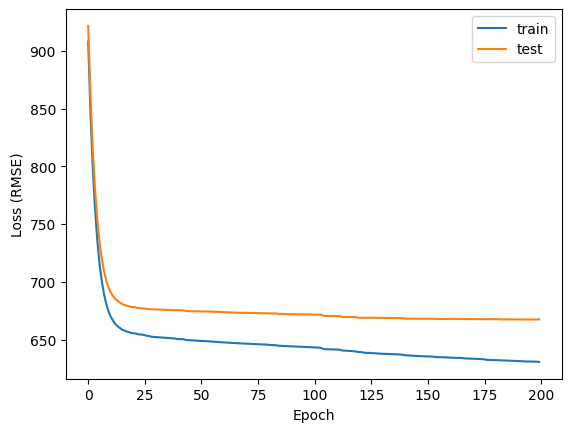

In [42]:
results = model.evals_result()

import matplotlib.pyplot as plt

plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
# show the plot
plt.show()

In [53]:
import random

randomIdx = random.sample(range(0, len(y_pred)), 5)

# print(y_val)

y_pred_sub = [y_pred[i] for i in randomIdx]
y_val_sub = [y_val.iloc[i] for i in randomIdx]

print(y_pred_sub)
print(y_val_sub)

[720.5774, 569.91516, 586.603, 793.52094, 899.19836]
[855, 795, 660, 1200, 1635]


In [27]:
# Preprocess testing data
trip_ids = test_data['TRIP_ID']
preprocessed_test_data = test_data.drop(['TRIP_ID', 'DAY_TYPE', 'MISSING_DATA'], axis=1)

preprocessed_test_data = pd.get_dummies(preprocessed_test_data, columns=['CALL_TYPE'])
preprocessed_test_data['CALL_TYPE'] = preprocessed_test_data['CALL_TYPE_A'].astype(int) + preprocessed_test_data['CALL_TYPE_B'].astype(int) * 2 + preprocessed_test_data['CALL_TYPE_C'].astype(int) * 3
preprocessed_test_data = preprocessed_test_data.drop(['CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C'], axis=1)

preprocessed_test_data['ORIGIN_CALL'].fillna(0, inplace=True)
preprocessed_test_data['ORIGIN_STAND'].fillna(0, inplace=True)

preprocessed_test_data['TAXI_ID'] = preprocessed_test_data['TAXI_ID'] - 20000000  # Normalize taxi IDs

preprocessed_test_data['TIMESTAMP'] = pd.to_datetime(preprocessed_test_data['TIMESTAMP'], unit='s')
preprocessed_test_data['HOUR'] = preprocessed_test_data['TIMESTAMP'].dt.hour
preprocessed_test_data['DAY_OF_WEEK'] = preprocessed_test_data['TIMESTAMP'].dt.dayofweek + 1
preprocessed_test_data['WEEK_OF_YEAR'] = preprocessed_test_data['TIMESTAMP'].dt.isocalendar().week.astype(int)
preprocessed_test_data = preprocessed_test_data.drop('TIMESTAMP', axis=1)

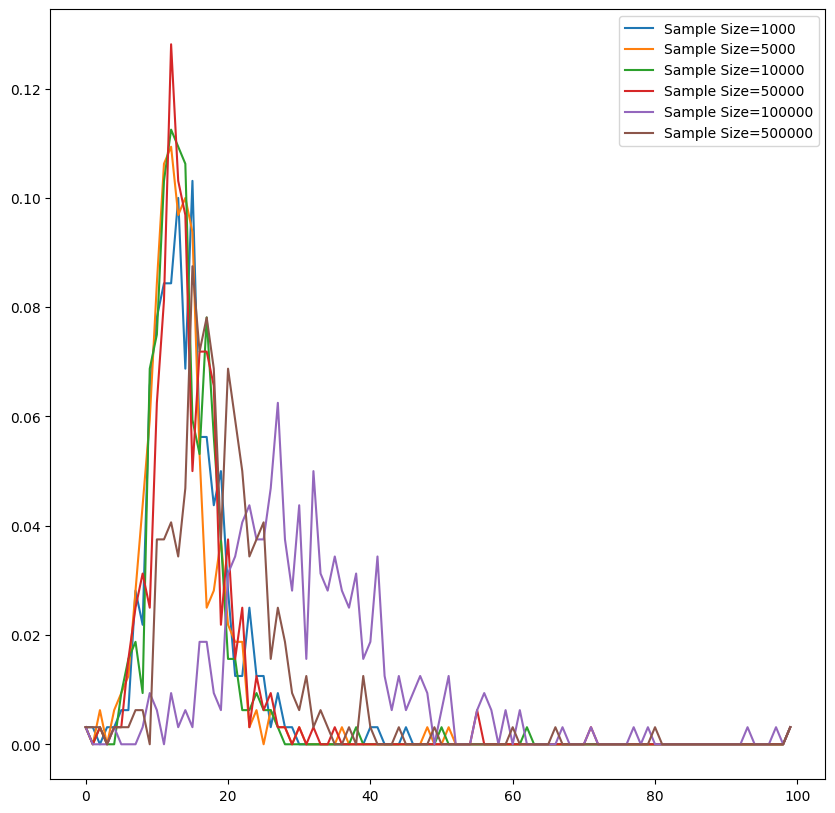

In [32]:
import matplotlib.pyplot as plt

train, val = train_test_split(preprocessed_data, test_size=0.2, random_state=42)

plt.figure(figsize=(10,10))
for size in [1000,5000,10000,50000,100000,500000]:
    train = train.sample(size, replace=True)
    X_train = train.drop(['POLYLINE', 'LEN'], axis=1)
    y_train = train['LEN']  # Calculate travel time in seconds
    X_val = val.drop(['POLYLINE', 'LEN'], axis=1)
    y_val = val['LEN']  # Calculate travel time in seconds

    model = xgb.XGBRegressor(n_estimators=200, max_depth=4)
    model.fit(X_train, y_train)

    results = model.predict(preprocessed_test_data)
    histogram, bin_boundary = np.histogram(results, bins=100)
    histogram = histogram / len(results)
    # The center is the left_bound and right_bound of a bucket
    # bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(histogram, label=f"Sample Size={size}")

plt.legend()

In [19]:
import csv

results = model.predict(preprocessed_test_data)
fields = ['TRIP_ID', 'TRAVEL_TIME']
rows = []

for i, result in enumerate(results):
    row = [str(trip_ids[i]), result]
    rows.append(row)

with open("submission.csv", 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)